# Семинар_4: XGBoost и Py-boost

Цель семинара: освоить подходы multilabel классификации библиотеками XGBoost и Py-boost

План семинара:

* Практика - решим нашу задачу в постановке multiclass с помощью библиотеки XGBoost
* Практика - переформулируем нашу задачу в multilabel и решим используя XGBoost
* Практика - освоим библиотеку Py-boost для задач multilabel 
* Подведение итогов - проанализируем и обсудим результаты

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn import metrics

import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
import pandas as pd
pd.set_option('display.max_columns', None)

# 1. Задача 1. XGBoost (20 минут)

* Был представлен в 2016 году
* По функционалу и интерфейсу очень похож на LightGBM
* Поддерживает кастомные метрики прямо из scikit-learn

Попробуем решить нашу задачу в постановке мультикласс используя библиотеку XGBoost

In [2]:
train = pd.read_csv('/kaggle/input/seminar1/train_multiclass.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')
train.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,target
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0,3
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1,6
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0,2
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0,2
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1,6


In [3]:
targets = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

X = train.drop(columns=targets + ['target', 'id'])
y = train['target']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                  random_state=43, stratify=y)

Класс DMatrix - оптимизированная как по занимаемой памяти, так и по скорости обучения структура данных, которая используется в XGBoost.

In [5]:
dtrain = xgb.DMatrix(X_train,
                     label=y_train,
                     nthread=-1)

dtest = xgb.DMatrix(X_test,
                    y_test,
                    nthread=-1)

* Обучите XGBoost Classifier. Найдите в документации [ссылка](https://xgboost.readthedocs.io/en/stable/parameter.html)  подходящий для нашей задачи objective (наша задача multiclass). Мы хотим на выходе получать вероятности для каждого из классов. Установите правильный objective и запустите ячейку. 
* Ячейка выдаст ошибку - попытайтесь ее исправить. 
* Проанализируйте логлосс на трейне и на валидации. Что может быть причиной такого поведения метрики?
* Попробуйте поиграться с параметрами (смотрим их в документации) и оцените метрики.
* Попробуйте DART режим. [ссылка](https://xgboost.readthedocs.io/en/stable/tutorials/dart.html) Дропаут регуляризация. В некоторых случаях позволяет добиться увеличения скора.

In [6]:
%%time
params = {
    'objective': 'multi:softprob',
    'tree_method': 'hist',
    'seed': 42,
    'num_class': 8,
}
booster = xgb.train(params,
                    dtrain=dtrain,
                    num_boost_round=100,
                    early_stopping_rounds=10,
                    evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
                    verbose_eval=5)

[0]	dtrain-mlogloss:1.65751	dtest-mlogloss:1.68326
[5]	dtrain-mlogloss:1.09306	dtest-mlogloss:1.20528
[10]	dtrain-mlogloss:0.92471	dtest-mlogloss:1.10840
[15]	dtrain-mlogloss:0.83844	dtest-mlogloss:1.07778
[20]	dtrain-mlogloss:0.77988	dtest-mlogloss:1.06945
[25]	dtrain-mlogloss:0.73854	dtest-mlogloss:1.06887
[30]	dtrain-mlogloss:0.69814	dtest-mlogloss:1.07350
[33]	dtrain-mlogloss:0.67835	dtest-mlogloss:1.07393
CPU times: user 4.34 s, sys: 28.6 ms, total: 4.37 s
Wall time: 1.12 s


In [7]:
y_pred_proba = booster.predict(dtest)

roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
roc_auc

0.8508012058914168

# GPU

Запустите на gpu. Какие параметры нужно поменять - смотрим в документацию.

In [8]:
%%time
params = {
    'objective': 'multi:softprob',
    'tree_method': 'hist',
    'device':'cuda',
    'seed': 42,
    'num_class': 8,
}
booster = xgb.train(params,
                    dtrain=dtrain,
                    num_boost_round=100,
                    early_stopping_rounds=10,
                    evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
                    verbose_eval=5)

[0]	dtrain-mlogloss:1.65731	dtest-mlogloss:1.68329
[5]	dtrain-mlogloss:1.09422	dtest-mlogloss:1.20540
[10]	dtrain-mlogloss:0.92520	dtest-mlogloss:1.10635
[15]	dtrain-mlogloss:0.84107	dtest-mlogloss:1.07883
[20]	dtrain-mlogloss:0.78424	dtest-mlogloss:1.06720
[25]	dtrain-mlogloss:0.73843	dtest-mlogloss:1.06753
[30]	dtrain-mlogloss:0.70273	dtest-mlogloss:1.06918
[32]	dtrain-mlogloss:0.68704	dtest-mlogloss:1.07165
CPU times: user 857 ms, sys: 125 ms, total: 982 ms
Wall time: 1.12 s


In [9]:
y_pred_proba = booster.predict(dtest)

roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
roc_auc

0.8511498462658157

# DART

* Запустите в режиме DART

In [10]:
%%time
params = {
    'objective': 'multi:softprob',
    'tree_method': 'hist',
    'seed': 42,
    'num_class': 8,
    'booster': 'dart',
    #'gamma': 2,
}


booster = xgb.train(params,
                    dtrain=dtrain,
                    num_boost_round=100,
                    early_stopping_rounds=10,
                    evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
                    verbose_eval=5)

[0]	dtrain-mlogloss:1.65751	dtest-mlogloss:1.68326
[5]	dtrain-mlogloss:1.09306	dtest-mlogloss:1.20528
[10]	dtrain-mlogloss:0.92471	dtest-mlogloss:1.10840
[15]	dtrain-mlogloss:0.83844	dtest-mlogloss:1.07778
[20]	dtrain-mlogloss:0.77988	dtest-mlogloss:1.06945
[25]	dtrain-mlogloss:0.73854	dtest-mlogloss:1.06887
[30]	dtrain-mlogloss:0.69814	dtest-mlogloss:1.07350
[32]	dtrain-mlogloss:0.68563	dtest-mlogloss:1.07387
CPU times: user 32.2 s, sys: 107 ms, total: 32.3 s
Wall time: 8.13 s


* Посмотрим на важность фичей. Каким образом ранжированны признаки по умолчанию?
* Поменяйте параметры plot_importance, чтобы сравить разные типы ранжирования.

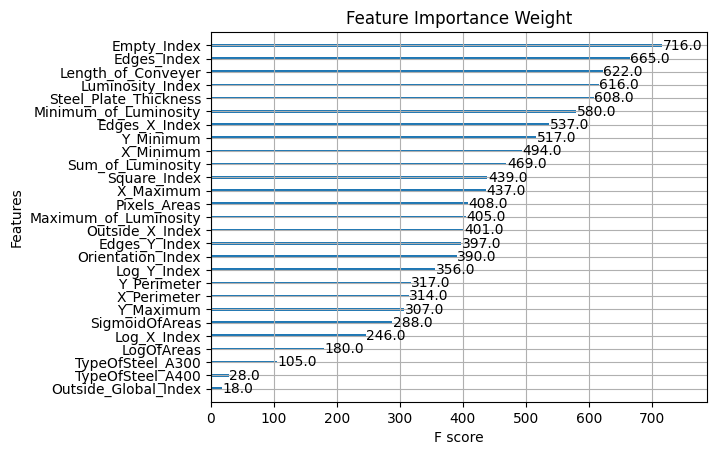

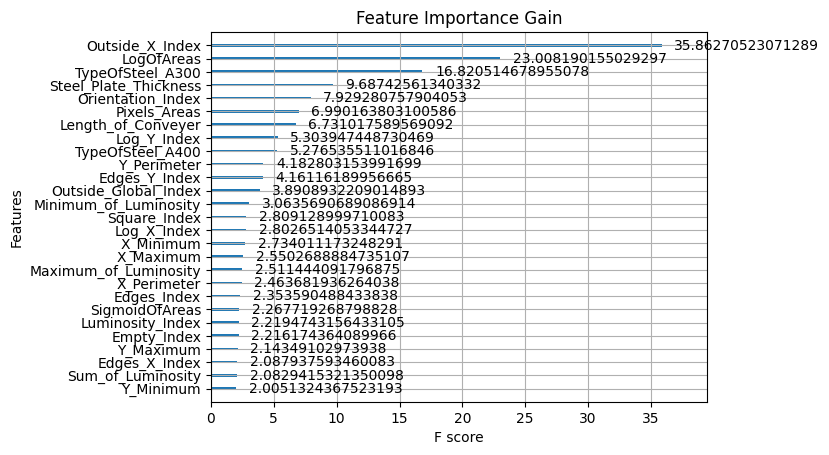

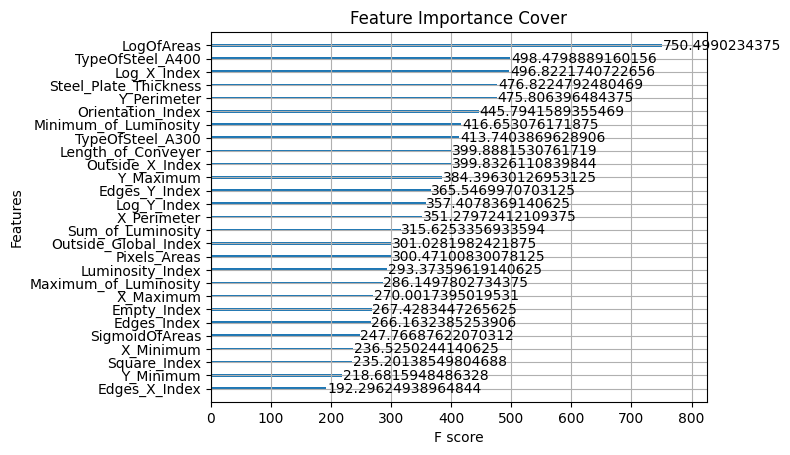

In [11]:
xgb.plot_importance(booster, title='Feature Importance Weight')
xgb.plot_importance(booster, importance_type='gain', title='Feature Importance Gain')
xgb.plot_importance(booster, importance_type='cover', title='Feature Importance Cover');

* ”weight” сколько раз признак появляется в дереве
* ”gain” is the average gain of splits which use the feature
* ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split средний охват сплитов, в которых присутствует фича. охват определяется как кол-во сэмплов, на которые повлиял сплит

* Теперь посчитаем roc_auc_score.

In [12]:
y_pred_proba = booster.predict(dtest)

roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
roc_auc

0.8508012058914168

# Задача 2 (10 мин)

Попробуем рассмотреть нашу задачу в контексте multi-label классификации.


* Сформируйте правильный таргет. Нам нужно получить датафрейм с отдельным столбцом для каждого дефекта. Всего семь столбцов.

In [13]:
X = train.drop(columns=targets + ['target', 'id'])
y = train[targets]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                  random_state=43)

In [15]:
clf = xgb.XGBClassifier(tree_method="hist",
                        seed=42,
                        n_estimators=100,
                        early_stopping_rounds=10,
                        #multi_strategy="multi_output_tree"
                       )
eval_set = [(X_train, y_train), (X_test, y_test)]
clf.fit(X_train, y_train, eval_set=eval_set,verbose=5)

[0]	validation_0-logloss:0.32725	validation_1-logloss:0.33221
[5]	validation_0-logloss:0.22112	validation_1-logloss:0.24060
[10]	validation_0-logloss:0.19573	validation_1-logloss:0.22735
[15]	validation_0-logloss:0.18297	validation_1-logloss:0.22570
[20]	validation_0-logloss:0.17415	validation_1-logloss:0.22625
[25]	validation_0-logloss:0.16567	validation_1-logloss:0.22759
[27]	validation_0-logloss:0.16284	validation_1-logloss:0.22822


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [16]:
y_pred_proba = clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
roc_auc

0.8786061873598214

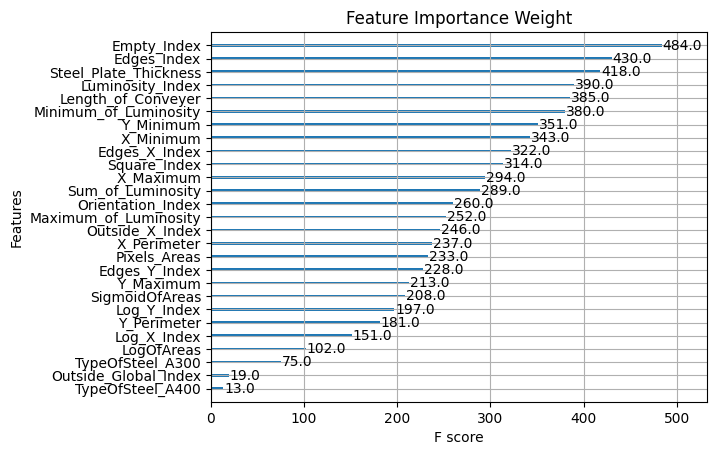

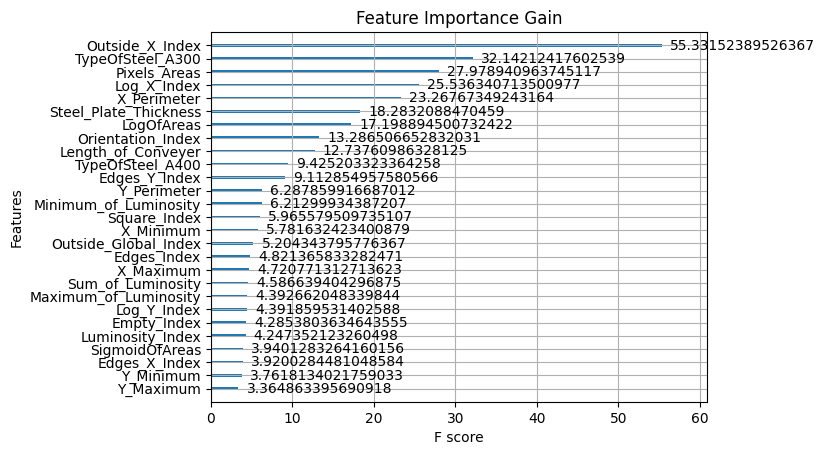

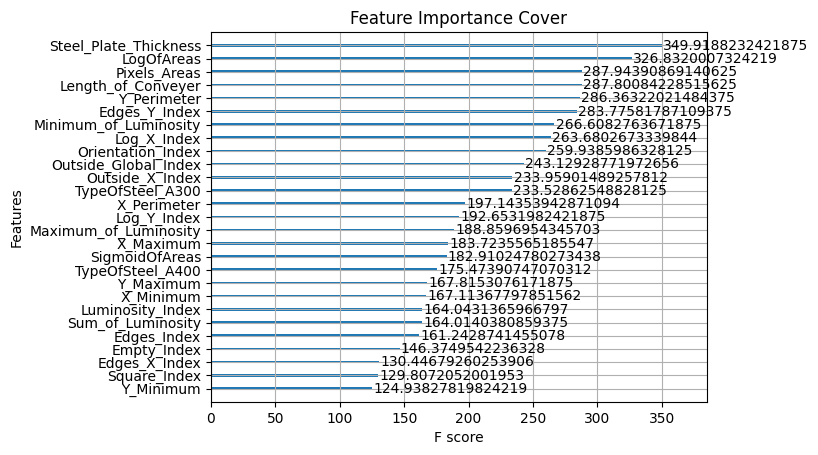

In [17]:
# Посмотрим импортансы для мультилэйбла
xgb.plot_importance(clf, title='Feature Importance Weight')
xgb.plot_importance(clf, importance_type='gain', title='Feature Importance Gain')
xgb.plot_importance(clf, importance_type='cover', title='Feature Importance Cover');

# Задача 3. Валидация для мультилэйбл задачи. (5 мин)

* Посмотрите на особенности валидации при multioutput training. 

* У нас есть всего 7 столбцов для таргета. В каждом из столбцов может стоять 0 или 1. 
* Но это не совсем про нашу задачу! У нас - значительно ограниченное кол-во комбинаций лэйблов 

* Посчитайте, какое кол-во возможных вариантов для таргета в теории (при условии, что могут быть любые комбинации из лейблов в таргете) может быть у одного семпла? (ответ: 2 в степени 7)
* Мы хотели бы сделать stritified kfold валидацию на 5 фолдах. Какое минимальное кол-во образцов нам понадобится, чтобы в каждом фолде был как минимум один пример для каждого из типа таргетов? (5 умножить на 2 ** 7) А если у нас всего бы было 12 лейблов? (5 умножить на 4096 т.е. 20к семплов, а попробуй научиться, когда у нас есть только один пример). 
* А если примеров не хватает на все фолды, или каких-то примеров нет?

Алгоритмы для валидации для мультилебла: можно погуглить статью :On the Stratification of Multi-Label Data. Sechidis K., Tsoumakas G., Vlahavas I. (2011)

Можно посмотреть библиотеку [ссылка](https://github.com/trent-b/iterative-stratification)

# PyBoost

# Задача 1.Разминка. Py-boost мультилейбл (10 мин)

* Разработан sber-ai-lab
* [гитхаб проекта](https://github.com/sb-ai-lab/Py-Boost) с исходным кодом и туториалами
* написан целиком на чистом пайтоне
* но быстрый, поскольку запускается на gpu
* также есть поддержка конвертации для инференса на cpu
* упор на multioutput training - до 40х быстрее других бустингов на мультилэйбл задачах
* поддерживает кастомные колбэки, кастомные функции потерь и метрики.

Установим библиотеку

In [18]:
!pip install py-boost -q

In [19]:
from py_boost import GradientBoosting
#Optional: set the device to run
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/opt/conda/lib/python3.10/site-packages/cudf/utils/_numba.py:110: UserWarning: Using CUDA toolkit version (12, 3) with CUDA driver version (12, 2) requires minor version compatibility, which is not yet supported for CUDA driver versions 12.0 and above. It is likely that many cuDF operations will not work in this state. Please install CUDA toolkit version (12, 2) to continue using cuDF.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


Забустим нашу модель. Обратите внимание на используемый лосс. Подумайте, почему используется именно такой. 

In [20]:
%%time
model = GradientBoosting('bce', ntrees=1000, seed=42)

model.fit(np.array(X_train), np.array(y_train), eval_sets=[{'X': np.array(X_test), 'y': np.array(y_test)},])

/opt/conda/lib/python3.10/site-packages/py_boost/quantization/utils.py:27: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  numba_apply_borders_1d(X[:, i], X_enc[:, i], borders[i])


[17:09:41] Stdout logging level is INFO.
[17:09:41] GDBT train starts. Max iter 1000, early stopping rounds 100
[17:11:29] Iter 0; Sample 0, BCE = 0.32993965632705613; 
[17:11:30] Iter 10; Sample 0, BCE = 0.2737554990524508; 
[17:11:30] Iter 20; Sample 0, BCE = 0.2503575947054122; 
[17:11:30] Iter 30; Sample 0, BCE = 0.23803830470141002; 
[17:11:30] Iter 40; Sample 0, BCE = 0.23151152659209015; 
[17:11:30] Iter 50; Sample 0, BCE = 0.22785383866603745; 
[17:11:31] Iter 60; Sample 0, BCE = 0.22545216718347486; 
[17:11:31] Iter 70; Sample 0, BCE = 0.22404459959785789; 
[17:11:31] Iter 80; Sample 0, BCE = 0.22313856733693327; 
[17:11:31] Iter 90; Sample 0, BCE = 0.2224687250850332; 
[17:11:32] Iter 100; Sample 0, BCE = 0.2221450953113566; 
[17:11:32] Iter 110; Sample 0, BCE = 0.22208453963852498; 
[17:11:32] Iter 120; Sample 0, BCE = 0.22200787140616063; 
[17:11:32] Iter 130; Sample 0, BCE = 0.2219043617137518; 
[17:11:32] Iter 140; Sample 0, BCE = 0.22185512358693152; 
[17:11:33] Iter 150

Оценим метрики

In [21]:
preds = model.predict(X_test)

roc_auc = roc_auc_score(y_test, preds, multi_class='ovo')
roc_auc

0.8840162985843458

Почему roc_auc получился такой маленький? Поменяйте лосс в нашей модели на правильный. [Туториал](https://github.com/sb-ai-lab/Py-Boost/blob/master/tutorials/Tutorial_1_Basics.ipynb) в помощь.

### Важность признаков

In [22]:
model.get_feature_importance()

array([363., 320., 386., 215., 231., 222., 195., 338., 425., 228., 423.,
        72.,  37., 560., 553., 540., 304., 292., 336., 325.,  17., 120.,
       193., 241., 289., 407., 153.], dtype=float32)

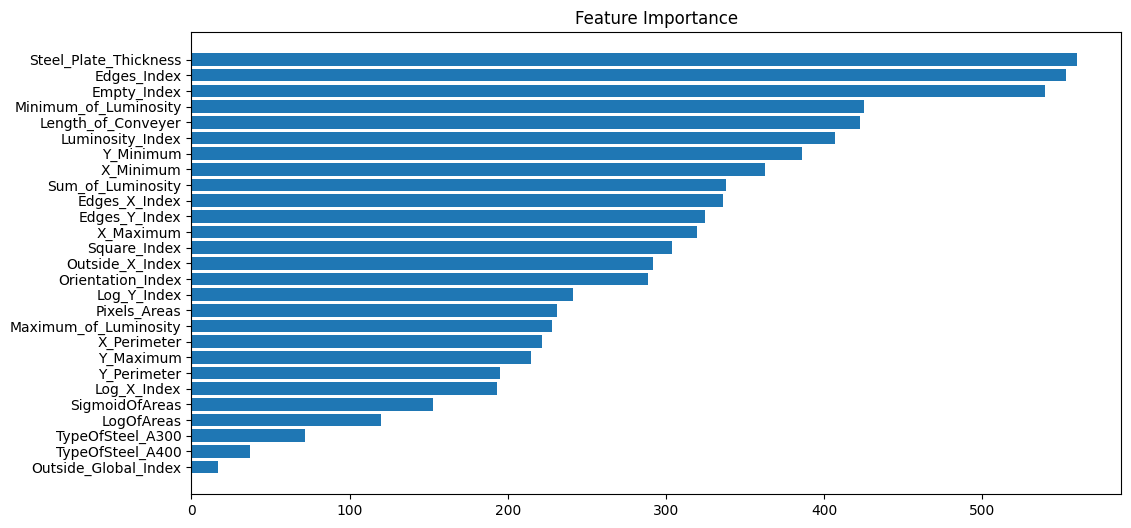

In [23]:
feature_importance = model.get_feature_importance(imp_type='split')
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

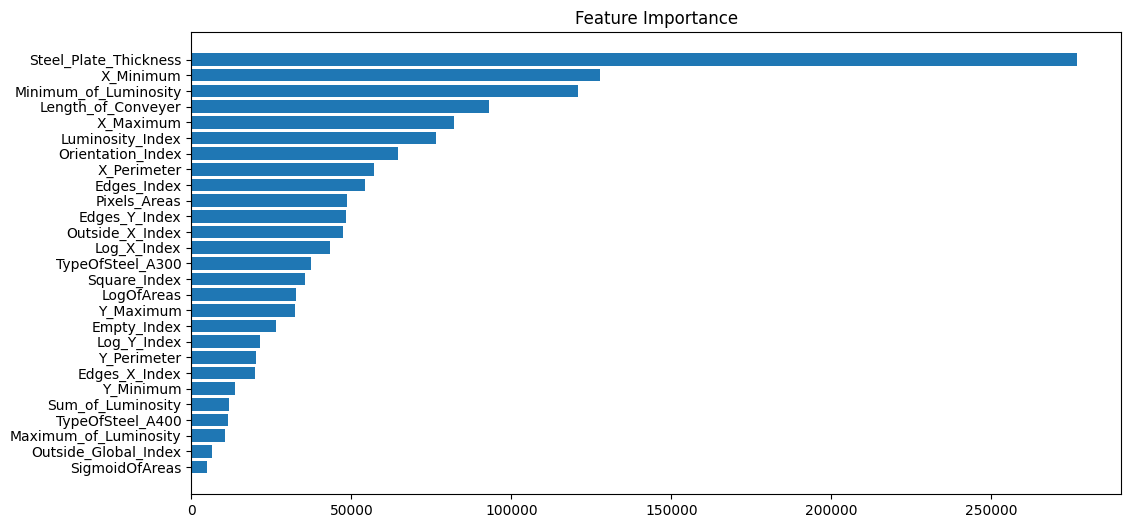

In [24]:
feature_importance = model.get_feature_importance(imp_type='gain')
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

#### *Заслать мультилэйбл сабмишн на ЛБ (если успеваете)

In [25]:
# подготовка файла для сабмишена
submission = pd.DataFrame(
    model.predict(test.drop(columns=['id'])),
    columns=targets,
    index=test.id
).reset_index()
submission.to_csv('submission.csv', index=False)
submission.head(5)

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.618815,0.003274,0.003184,0.000413,0.023475,0.143540,0.312913
1,19220,0.327400,0.018777,0.012209,0.001126,0.132024,0.167849,0.348345
2,19221,0.002351,0.056694,0.056176,0.002530,0.005165,0.304460,0.524473
3,19222,0.112155,0.002606,0.002442,0.002525,0.016099,0.428714,0.393683
4,19223,0.009736,0.002972,0.002552,0.004250,0.015563,0.497292,0.404825


In [26]:
submission.to_csv('submission.csv', index=False)

# Задача 2 (15 мин)

Бывает так, что у нужной библеотеки нет документации.
* Мы хотим поиграться с параметрами пайбуста. Как поступить в таком случае?
* Первый вариант - посмотреть туториалы на гитхабе проекта.
* Второй вариант - вызвать список доступных аттрибутов у нашей модели.
* Задание: Вызовите все доступные аттрибуты и попробуйте позапускать модель с новыми значениями аттрибутов.

In [27]:
model = GradientBoosting('bce')
model.__dict__

{'models': None,
 'nfeats': None,
 'postprocess_fn': <function py_boost.gpu.base.Ensemble._default_postprocess_fn(x)>,
 'base_score': None,
 '_on_device': False,
 'quantization': 'Quantile',
 'quant_sample': 200000,
 'max_bin': 256,
 'min_data_in_bin': 3,
 'seed': 42,
 'params': {'loss': 'bce',
  'metric': None,
  'ntrees': 100,
  'lr': 0.05,
  'min_gain_to_split': 0,
  'lambda_l2': 1,
  'gd_steps': 1,
  'max_depth': 6,
  'min_data_in_leaf': 10,
  'colsample': 1.0,
  'subsample': 1.0,
  'target_splitter': 'Single',
  'multioutput_sketch': None,
  'use_hess': True,
  'quantization': 'Quantile',
  'quant_sample': 2000000,
  'max_bin': 256,
  'min_data_in_bin': 3,
  'es': 100,
  'seed': 42,
  'verbose': 10,
  'callbacks': None,
  'debug': False}}

In [28]:
model.fit(np.array(X_train), np.array(y_train), eval_sets=[{'X': np.array(X_test), 'y': np.array(y_test)},])

[17:11:38] Stdout logging level is INFO.
[17:11:38] GDBT train starts. Max iter 100, early stopping rounds 100
[17:11:38] Iter 0; Sample 0, BCE = 0.3299396565428283; 
[17:11:38] Iter 10; Sample 0, BCE = 0.27375669396889885; 
[17:11:38] Iter 20; Sample 0, BCE = 0.2503590621240833; 
[17:11:38] Iter 30; Sample 0, BCE = 0.23803895054788313; 
[17:11:39] Iter 40; Sample 0, BCE = 0.2315109818378444; 
[17:11:39] Iter 50; Sample 0, BCE = 0.227853418206174; 
[17:11:39] Iter 60; Sample 0, BCE = 0.22545171798780644; 
[17:11:39] Iter 70; Sample 0, BCE = 0.2240461550933744; 
[17:11:39] Iter 80; Sample 0, BCE = 0.22314120999336384; 
[17:11:40] Iter 90; Sample 0, BCE = 0.22247314962963327; 
[17:11:40] Iter 99; Sample 0, BCE = 0.2222207501877742; 


### Sketching

Идея метода заключается в приближенном вычислении оценочной функции, используемой для поиска наилучшего разделения деревьев решений.


Библиотекой поддерживаются разные типы скетчинга, упрощающие поиск среди структур деревьев. [Туториал](https://github.com/sb-ai-lab/Py-Boost/blob/master/tutorials/Tutorial_2_Advanced_multioutput.ipynb) по скетчингу.
* Попробуйте запустить бустинг с параметром multioutput_sketch. Сравните скорость и roc_auc со скетчингом и без.

In [29]:
from py_boost.multioutput.sketching import *

In [30]:
%%time
#sketch = RandomProjectionSketch(1)
sketch = RandomSamplingSketch(10)
#sketch = TopOutputsSketch(10)
#sketch = SVDSketch(n_components=1)

model = GradientBoosting('bce',
                         multioutput_sketch=sketch,
                        )

model.fit(np.array(X_train), np.array(y_train), eval_sets=[{'X': np.array(X_test), 'y': np.array(y_test)},])

[17:11:40] Stdout logging level is INFO.
[17:11:40] GDBT train starts. Max iter 100, early stopping rounds 100
[17:11:47] Iter 0; Sample 0, BCE = 0.3315366681846803; 
[17:11:47] Iter 10; Sample 0, BCE = 0.27576181457213494; 
[17:11:48] Iter 20; Sample 0, BCE = 0.2519992658572767; 
[17:11:48] Iter 30; Sample 0, BCE = 0.23959449880383124; 
[17:11:48] Iter 40; Sample 0, BCE = 0.23174696875783676; 
[17:11:49] Iter 50; Sample 0, BCE = 0.22772532253689864; 
[17:11:49] Iter 60; Sample 0, BCE = 0.2252013363101334; 
[17:11:49] Iter 70; Sample 0, BCE = 0.22368403643614373; 
[17:11:49] Iter 80; Sample 0, BCE = 0.22250764903864756; 
[17:11:50] Iter 90; Sample 0, BCE = 0.22200896631054642; 
[17:11:50] Iter 99; Sample 0, BCE = 0.22168043326358822; 
CPU times: user 9.55 s, sys: 121 ms, total: 9.67 s
Wall time: 9.65 s


In [31]:
preds = model.predict(X_test)

roc_auc = roc_auc_score(y_test, preds, multi_class='ovo')
roc_auc

0.8854339555381916

# Задача 3. Py-boost мультикласс (10 мин)

Давайте также решим мультикласс задачу пайбустом

In [32]:
X = train.drop(columns=targets + ['target', 'id'])
y = train['target']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                  random_state=43, stratify=y)

* Какой лосс будем использовать?

In [34]:
%%time
model = GradientBoosting('crossentropy')

model.fit(np.array(X_train), np.array(y_train), eval_sets=[{'X': np.array(X_test), 'y': np.array(y_test)},])

[17:11:51] Stdout logging level is INFO.
[17:11:51] GDBT train starts. Max iter 100, early stopping rounds 100
[17:11:53] Iter 0; Sample 0, Crossentropy = 1.9650008302841158; 
[17:11:53] Iter 10; Sample 0, Crossentropy = 1.4431658730479255; 
[17:11:53] Iter 20; Sample 0, Crossentropy = 1.254118434796822; 
[17:11:54] Iter 30; Sample 0, Crossentropy = 1.1611109339983807; 
[17:11:54] Iter 40; Sample 0, Crossentropy = 1.112922535438806; 
[17:11:54] Iter 50; Sample 0, Crossentropy = 1.089514401370251; 
[17:11:54] Iter 60; Sample 0, Crossentropy = 1.073938898336478; 
[17:11:55] Iter 70; Sample 0, Crossentropy = 1.0652814213104556; 
[17:11:55] Iter 80; Sample 0, Crossentropy = 1.058540636515272; 
[17:11:55] Iter 90; Sample 0, Crossentropy = 1.0542509068756947; 
[17:11:55] Iter 99; Sample 0, Crossentropy = 1.0511722431652526; 
CPU times: user 4.76 s, sys: 28 ms, total: 4.79 s
Wall time: 4.72 s


In [35]:
preds = model.predict(X_test)

roc_auc_score(y_test, preds, multi_class='ovo')

0.8608067340203841

* Посмотрим на feature_importance

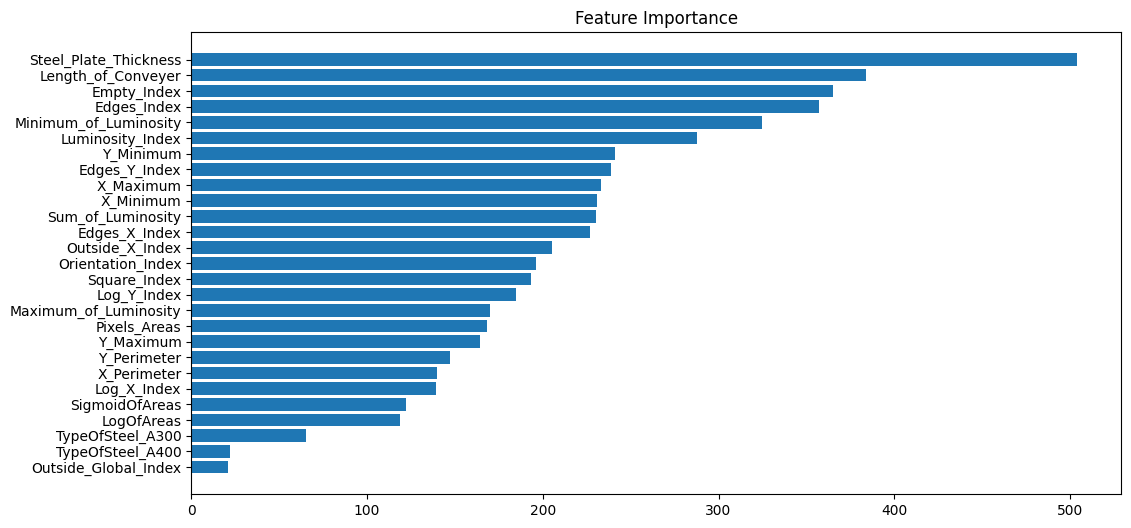

In [36]:
feature_importance = model.get_feature_importance(imp_type='split')
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');